In [1]:
import os
from tifffile import imread
from skimage.measure import regionprops
from scipy.ndimage import find_objects
import numpy as np
import nd2
import pandas as pd

from scipy.ndimage import affine_transform
from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm

import seaborn as sns
import plotly.express as px

from napari_builtins.io import csv_to_layer_data

In [2]:
def get_affine_from_points(x, x_prime):
    X = np.kron(np.eye(3), np.concat([x, np.ones((x.shape[0], 1))], axis=1)[:, np.newaxis, :]).reshape(x.shape[0]*3, 12)
    res = np.linalg.lstsq(X, x_prime.flatten())
    return get_affine(res[0]), res

def get_affine(a):
    affine = np.eye(4)
    affine[:3] = a.reshape(3, 4)
    return affine

In [3]:
def calc_ratios(values):
    means = np.concat((
        np.mean(values, axis=0)[np.newaxis, :],
        np.percentile(values, q=[50, 75, 90, 95], axis=0),
    ), axis=0)
    return np.concat((means[:, 1] / means[:, 0], means[:, 0], means[:, 1]))

value_vars = ["mean", "median", "75 %", "90 %", "95 %"]
def calc_df(img, lbl):
    lbl = lbl[:img.shape[0]]
    #bg = np.median(img[lbl==0], axis=0)
    #img = np.clip(img - bg, 1, None)
    
    objects = find_objects(lbl)

    values = []
    lbl_id = []
    for i, sl in enumerate(objects, 1):
        if sl is None: continue
        mask = lbl[sl] == i
        values.append(calc_ratios(img[sl][mask]))
        lbl_id.append(i)
    values_np = np.stack(values, axis=0)

    dfs = []
    for j, ty in enumerate(["ratio", "mScarlet", "gfp"]):
        values = {t: values_np[:, i+j*len(value_vars)] for i, t in enumerate(value_vars)}
        values["lbl_id"] = lbl_id
        values["type"] = ty
        dfs.append(pd.DataFrame(values))

    return pd.concat(dfs, ignore_index=True)

def get_props(lbl):
    objects = find_objects(lbl)
    for i, sl in enumerate(objects, 1):
        if sl is None: continue
        mask = lbl[sl] == i
        if mask.sum() < 30:
            imprint = lbl[sl]
            imprint[mask] = 0
            lbl[sl] = imprint
    
    props = regionprops(lbl)
    parameters = [
        "label",
        #"eccentricity",
        "axis_major_length",
        "axis_minor_length",
        "area",
        #"solidity",
        #"perimeter",
    ]
    values = {v: [] for v in parameters}
    for p in props:
        try:
            tmp = {v: p[v] for v in parameters}
        except ValueError:
            print("Skipping lbl_id", p["label"])
            continue
        for v in parameters:
            values[v].append(tmp[v])

    df = pd.DataFrame(values)
    df["aspect ratio"] = df["axis_major_length"] / df["axis_minor_length"]
    return df

In [4]:
def get_melt_df(img, lbl0, lbl1):
    df0 = calc_df(img[0], lbl0)
    df1 = calc_df(img[1], lbl1)
    
    props_df0 = get_props(lbl0)
    props_df1 = get_props(lbl1)
    props_df = props_df0.merge(props_df1, left_on="label", right_on="label", suffixes=("_0", "_1"))

    dfs = []
    for i in ["ratio", "gfp", "mScarlet"]:
        tmp0 = df0.loc[df0["type"] == i, ["median", "lbl_id"]]
        tmp1 = df1.loc[df1["type"] == i, ["median", "lbl_id"]]
    
        merge = tmp0.merge(tmp1, left_on="lbl_id", right_on="lbl_id", suffixes=("_0", "_1"))
    
        merge = merge[merge["median_1"] > 0]
        merge = merge[merge["median_0"] > 0]
        
        merge["ratio"] = merge["median_1"] / merge["median_0"]
        merge["diff"] = merge["median_1"] - merge["median_0"]
    
        dfs.append(merge)

    df = dfs[0].merge(dfs[1], left_on="lbl_id", right_on="lbl_id", suffixes=("_ratio", "_gfp"))
    df = df.merge(dfs[2], left_on="lbl_id", right_on="lbl_id")
    df = df.merge(props_df, left_on="lbl_id", right_on="label")
    
    df = df[(df["aspect ratio_0"] > 2) & (df["aspect ratio_1"] > 2)]
    
    return df

In [5]:
def reassign_labels(new_lbl, lbl):
    cost_matrix = np.zeros((new_lbl.max(), lbl.max()), dtype=int)
    inds = np.logical_and(new_lbl > 0, lbl > 0)
    
    for i, j in zip(new_lbl[inds]-1, lbl[inds]-1):
        cost_matrix[i, j] += 1

    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)
    assignment = {int(k+1): int(v+1) for k, v in zip(col_ind, row_ind) if cost_matrix[v, k] > 10}

    final_lbl = np.zeros_like(lbl)
    for i, sl in enumerate(find_objects(lbl), 1):
        if sl is None: continue
        if i not in assignment: continue
        mask = lbl[sl] == i
        new_tmp = final_lbl[sl]
        new_tmp[mask] = assignment[i]
    return final_lbl

In [6]:
def get_lbl_img(pos, file):
    filename = f"{file}_t{{t}}_m{pos}_mScarlet.tiff"
    lbl0 = imread(os.path.join(root, "nfmp_prob0.5", model, filename.format(t=0)))
    lbl1 = imread(os.path.join(root, "nfmp_prob0.5", model, filename.format(t=1)))

    points = [
        csv_to_layer_data(os.path.join(root, "alignment", f"{file}_m{pos}_t{i}.csv"))[0]
        for i in range(2)
    ]
    affine = get_affine_from_points(*points)[0]
    
    warped_lbl = affine_transform(
        lbl0,
        np.linalg.inv(affine),
        output_shape=lbl0.shape,
        mode="constant", cval=np.nan,
        order=0,
    )

    with nd2.ND2File(os.path.join(root, file+".nd2")) as nd2_file:
        img = nd2_file.to_dask()[:, pos, :, 1:].compute().transpose(0, 1, 3, 4, 2)
    
    return img, lbl0, warped_lbl, lbl1

In [7]:
root = "/mnt/z/Dasha/2. FAST-AB biosensors/Microscope/Inverted bladder model/NCCRBM_114/To analyze for the figure"
model = "2026_01_05_Dasha_ibm-02"
files = [f"Fig.4_h_TrimFABS_ANOX_mScarlet_insert{i}" for i in [1, 3, 4]]

In [8]:
dfs = []
for file in tqdm(files):
    for pos in trange(3):
        img, lbl0, warped_lbl, lbl1 = get_lbl_img(pos, file)
        new_lbl1 = reassign_labels(warped_lbl, lbl1)
        tmp = get_melt_df(img, lbl0, new_lbl1)
        tmp["file"] = file
        tmp["pos"] = pos
        dfs.append(tmp)

df = pd.concat(dfs, ignore_index=True)
df

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Skipping lbl_id 1865


,median_0_ratio,lbl_id,median_1_ratio,ratio_ratio,diff_ratio,median_0_gfp,median_1_gfp,ratio_gfp,diff_gfp,median_0,...,axis_major_length_0,axis_minor_length_0,area_0,aspect ratio_0,axis_major_length_1,axis_minor_length_1,area_1,aspect ratio_1,file,pos
0,1.068376,3,1.363184,1.275940,0.294808,250.0,274.0,1.096000,24.0,234.0,...,49.885016,5.124867,878.0,9.733914,25.835803,4.906638,345.0,5.265479,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,0
1,1.066667,4,1.397380,1.310044,0.330713,248.0,320.0,1.290323,72.0,232.5,...,83.410672,8.333947,1710.0,10.008544,22.952205,5.192525,489.0,4.420239,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,0
2,0.849462,5,1.316742,1.550089,0.467280,237.0,291.0,1.227848,54.0,279.0,...,43.199235,6.795852,973.0,6.356707,30.912958,6.013700,582.0,5.140423,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,0
3,1.121560,6,1.425926,1.271378,0.304366,244.5,308.0,1.259714,63.5,218.0,...,45.270500,5.024990,688.0,9.009073,28.685937,5.613757,413.0,5.109935,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,0
4,1.027311,7,1.376147,1.339562,0.348836,244.5,300.0,1.226994,55.5,238.0,...,48.027554,6.373799,784.0,7.535154,55.885394,6.204059,1053.0,9.007876,Fig.4_h_TrimFABS_ANOX_mScarlet_insert1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5907,0.702350,1591,1.251216,1.781470,0.548866,269.0,386.0,1.434944,117.0,383.0,...,12.302293,4.340774,174.0,2.834124,25.351489,5.869171,570.0,4.319432,Fig.4_h_TrimFABS_ANOX_mScarlet_insert4,2
5908,0.782765,1606,1.333333,1.703364,0.550569,218.0,324.0,1.486239,106.0,278.5,...,11.639342,4.678889,168.0,2.487629,27.002258,6.094557,768.0,4.430553,Fig.4_h_TrimFABS_ANOX_mScarlet_insert4,2
5909,0.681293,1612,2.059406,3.022789,1.378113,295.0,624.0,2.115254,329.0,433.0,...,6.741772,3.369931,43.0,2.000567,14.329864,4.903229,191.0,2.922536,Fig.4_h_TrimFABS_ANOX_mScarlet_insert4,2
5910,0.908784,1621,1.630952,1.794654,0.722169,269.0,411.0,1.527881,142.0,296.0,...,13.265206,3.438056,137.0,3.858345,54.634460,5.971591,1041.0,9.149063,Fig.4_h_TrimFABS_ANOX_mScarlet_insert4,2


In [24]:
df["area ratio"] = df["area_1"] / df["area_0"]

tmp_df = df
df_melt = tmp_df.melt(id_vars=["lbl_id", "file", "pos"], value_vars=["ratio_ratio", "ratio_gfp", "ratio"])
df_melt.to_excel(
    "/mnt/z/Dasha/2. FAST-AB biosensors/Microscope/Inverted bladder model/NCCRBM_114/To analyze for the figure/2026-01-21-source-data-ratio-of-ratios.xlsx"
)

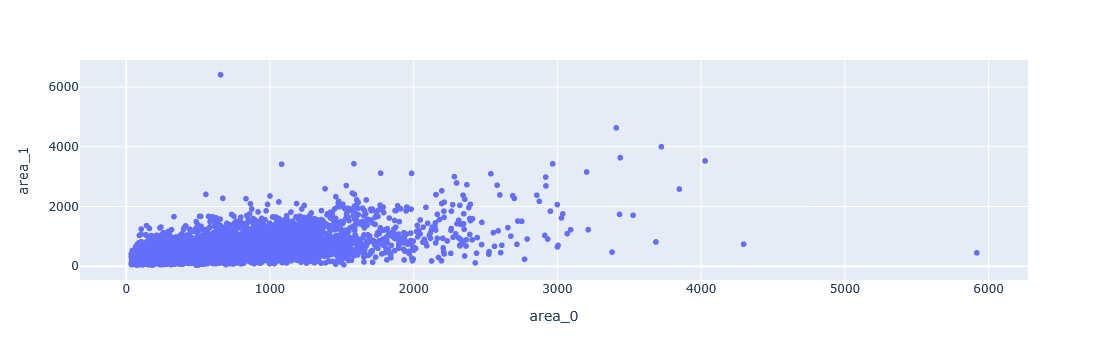

In [11]:
px.scatter(
    tmp_df,
    x="area_0",
    y="area_1",
)

<Axes: xlabel='variable', ylabel='value'>

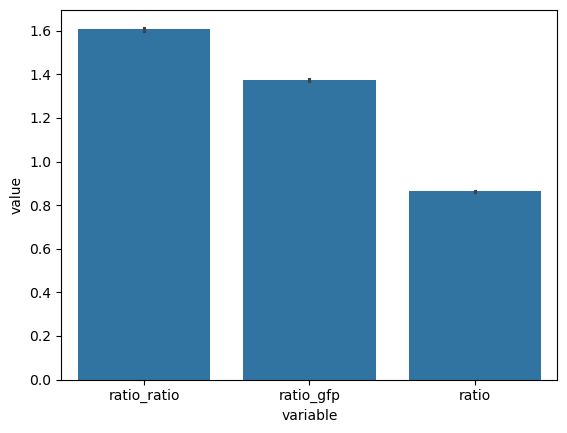

In [12]:
sns.barplot(
    df_melt,
    x="variable",
    y="value",
)

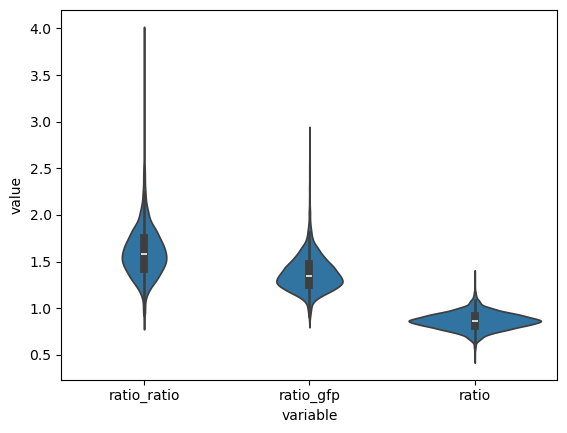

In [25]:
sns.violinplot(
    df_melt,
    x="variable",
    y="value",
)

plt.savefig("/mnt/z/Dasha/2. FAST-AB biosensors/Microscope/Inverted bladder model/NCCRBM_114/To analyze for the figure/2026-01-21-ratio-of-ratios-violin.svg")

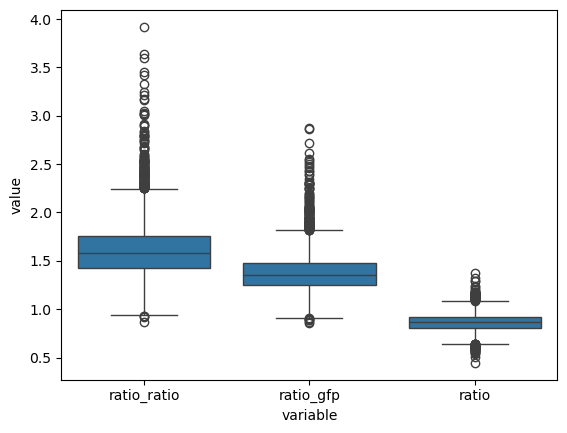

In [26]:
sns.boxplot(
    df_melt,
    x="variable",
    y="value",
)
plt.savefig("/mnt/z/Dasha/2. FAST-AB biosensors/Microscope/Inverted bladder model/NCCRBM_114/To analyze for the figure/2026-01-21-ratio-of-ratios-box.svg")

In [15]:
vals = tmp_df[["ratio_ratio", "ratio_gfp", "ratio"]].quantile([0.25, 0.5, 0.75])
vals

,ratio_ratio,ratio_gfp,ratio
0.25,1.425254,1.246964,0.807666
0.50,1.579898,1.348837,0.863491
0.75,1.754047,1.475410,0.920173


In [21]:
vals.T[0.75] - vals.T[0.25]

ratio_ratio    0.328793
ratio_gfp      0.228446
ratio          0.112507
dtype: float64

In [16]:
vals["ratio_gfp"] / vals["ratio"]

0.25    1.543909
0.50    1.562074
0.75    1.603405
dtype: float64

In [17]:
tmp_df[["ratio_ratio", "ratio_gfp", "ratio"]].mean()

ratio_ratio    1.607102
ratio_gfp      1.375254
ratio          0.864610
dtype: float64

In [18]:
tmp_df[["ratio_ratio", "ratio_gfp", "ratio"]].std()

ratio_ratio    0.276911
ratio_gfp      0.191733
ratio          0.090073
dtype: float64

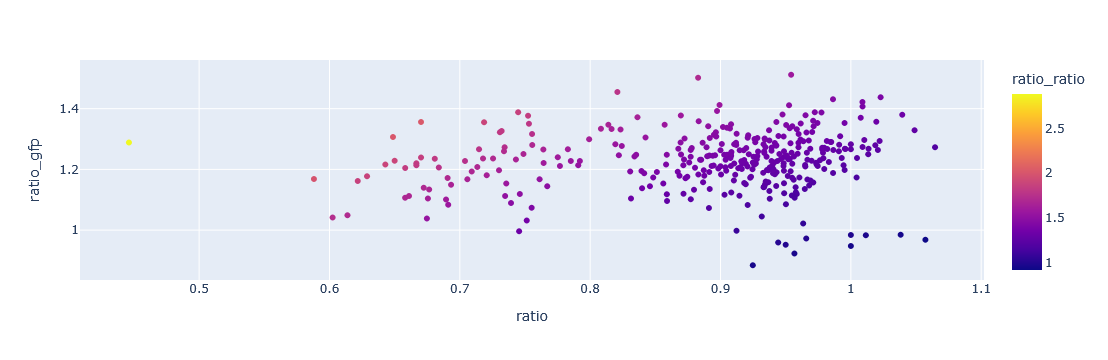

In [171]:
px.scatter(
    tmp_df,
    x="ratio",
    y="ratio_gfp",
    color="ratio_ratio",
    #hover_data=["file", "pos", "lbl_id"],
    hover_data=["lbl_id"],
)

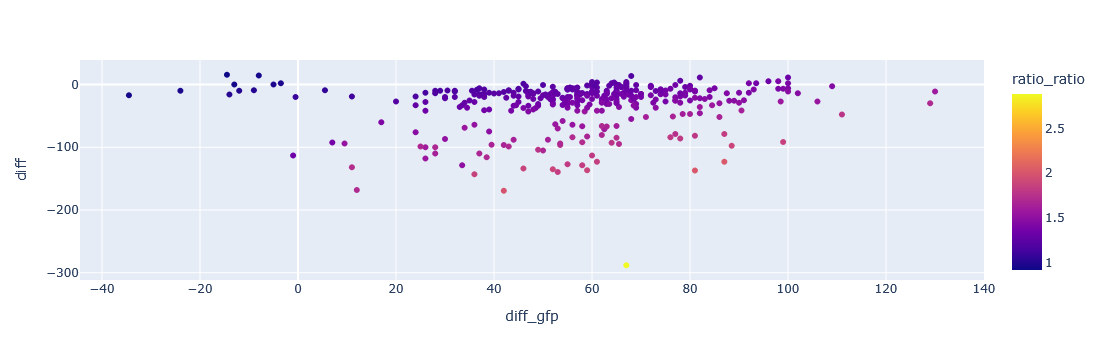

In [172]:
px.scatter(
    tmp_df,
    x="diff_gfp",
    y="diff",
    color="ratio_ratio",
    #hover_data=["file", "pos", "lbl_id"],
    hover_data=["lbl_id"],
)

In [147]:
tmp_df[tmp_df["lbl_id"] == 200]

,median_0_ratio,lbl_id,median_1_ratio,ratio_ratio,diff_ratio,median_0_gfp,median_1_gfp,ratio_gfp,diff_gfp,median_0,...,label,axis_major_length_0,axis_minor_length_0,area_0,aspect ratio_0,axis_major_length_1,axis_minor_length_1,area_1,aspect ratio_1,area ratio
146,0.006849,200,1.413793,206.413793,1.406944,1.0,82.0,82.0,81.0,146.0,...,200,42.154386,4.996952,652.0,8.43602,17.887891,4.951719,261.0,3.612461,0.400307


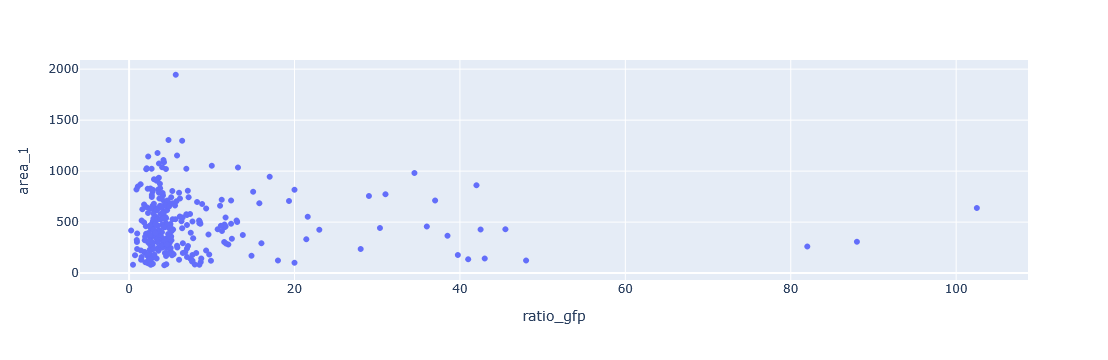

In [131]:
px.scatter(
    tmp_df,
    x="ratio_gfp",
    y="area_1",
    #color="ratio_ratio",
    #hover_data=["file", "pos", "lbl_id"],
    hover_data=["lbl_id"],
)

In [114]:
sns.stripplot(
    merge,
    y="ratio",
)

NameError: name 'merge' is not defined

<Axes: xlabel='area', ylabel='ratio'>

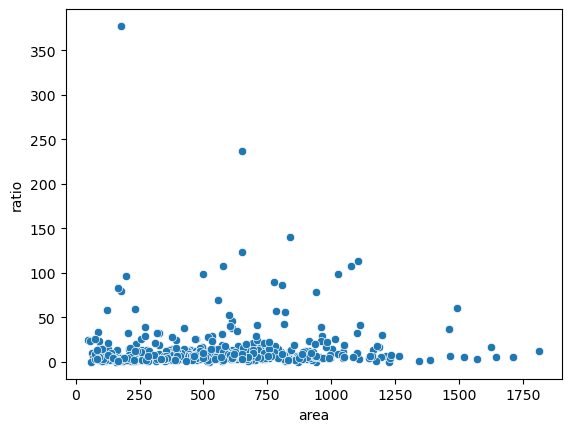

In [133]:
sns.scatterplot(
    merge,
    x="area",
    y="ratio",
)

In [134]:
vals = merge["ratio"].quantile([0.25, 0.5, 0.75])
print(vals[0.5], vals[0.75]-vals[0.25])

6.264594177752073 8.846919971919972


In [135]:
vals

0.25     3.924509
0.50     6.264594
0.75    12.771429
Name: ratio, dtype: float64

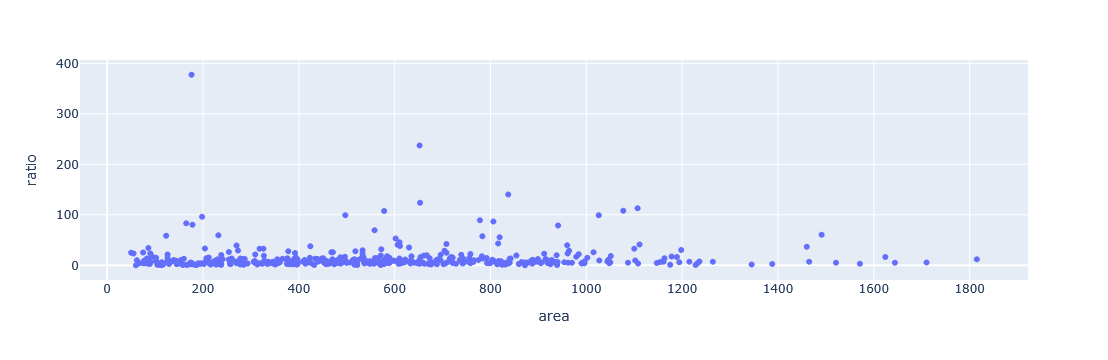

In [136]:
px.scatter(
    merge,
    x="area",
    y="ratio",
    hover_data=["lbl_id"],
)

In [110]:
np.argwhere(lbl0 == 538)

array([[  10,   65, 1112],
       [  11,   65, 1111],
       [  11,   65, 1112],
       [  11,   65, 1113],
       [  11,   66, 1108],
       [  11,   66, 1109],
       [  11,   66, 1110],
       [  11,   66, 1111],
       [  11,   66, 1112],
       [  12,   64, 1109],
       [  12,   64, 1110],
       [  12,   64, 1111],
       [  12,   64, 1112],
       [  12,   64, 1113],
       [  12,   65, 1108],
       [  12,   65, 1109],
       [  12,   65, 1110],
       [  12,   65, 1111],
       [  12,   65, 1112],
       [  12,   65, 1113],
       [  12,   65, 1114],
       [  12,   65, 1115],
       [  12,   66, 1107],
       [  12,   66, 1108],
       [  12,   66, 1109],
       [  12,   66, 1110],
       [  12,   66, 1111],
       [  12,   66, 1112],
       [  12,   66, 1113],
       [  12,   66, 1114],
       [  12,   67, 1107],
       [  12,   67, 1108],
       [  12,   67, 1109],
       [  12,   67, 1110],
       [  12,   67, 1111]])